# April

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

The mid-price:
$$ M = \frac{P^a + P^b}{2} $$ 

The weighted mid-price:
$$ W = P^b (1 - I) + P^a I $$ 

The imbalance:
$$ I = \frac{Q^b}{Q^a + Q^b} $$ 

The bid-ask spread:
$$ S = P^a - P^b $$

In [2]:
def get_df(month):
    
    file1 = 'Moex_%s.csv'%str(month)
    df = pd.read_csv(file1)
    df.columns = ['date','time','bid','bs','ask','as']       # bs, as = bid size , ask size 
    df = df.dropna()
    df['date'] = df['date'].astype(float)
    df['time'] = df['time'].astype(float)
    df['bid'] = df['bid'].astype(float)
    df['ask'] = df['ask'].astype(float)
    df['bs'] = df['bs'].astype(float)
    df['as'] = df['as'].astype(float)
    df['mid'] = (df['bid'].astype(float) + df['ask'].astype(float)) / 2                        # mid = mid-price
    df['imb'] = df['bs'].astype(float) / (df['bs'].astype(float) + df['as'].astype(float))     # imb = imbalance
    df['wmid'] = df['ask'].astype(float)*df['imb'] + df['bid'].astype(float) * (1 - df['imb'])   # wmid = weighted mid-price
    
    return df

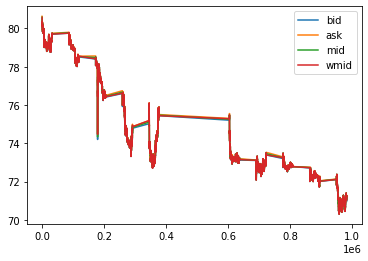

In [3]:
data = get_df('apr')
data.head()
data[['bid','ask','mid','wmid']].plot()

In [4]:
month = 'apr'
data = get_df(month) 

# Переходим к подсчету micro-price

In [5]:
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [6]:
def prep_data_sym(T, n_imb, dt, n_spread):
    
    spread = T.ask - T.bid
    #ticksize = np.round(min(spread[spread > 0]) * 100)/100
    ticksize = np.round(min(spread[spread > 0]), decimals = 4)
    
    # adds the spread and mid prices
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize           # считаем спред как кол-во тиков * размер тика
    # T['mid'] = (T['bid'] + T['ask'])/2   mid уже есть в подающемся на вход T
    
    #filter out spreads >= n_spread                        
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    #T['imb'] = T['bs'] / (T['bs'] + T['as'])   imb уже есть в подающемся на вход T
    
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)     # на n_imb - тили разбиваем imb. дискретизируем как бы 
    T['next_mid'] = T['mid'].shift(-dt)                          # следующее значение (через время dt)
    
    #step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)  
    
    # step ahead change in price
    T['dM'] = np.round((T['next_mid'] - T['mid']) / ticksize*2 )*ticksize/2      # на пополам, потому что цена средняя, и когда бид или аск меняется на тик, среднее меняется на половину тика
    
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM >= -ticksize*1.1)]          
    
    
    # symetrize data
    T2 = T.copy()                                                       
    T2['imb_bucket'] = n_imb - 1 - T2['imb_bucket']
    T2['next_imb_bucket'] = n_imb - 1 - T2['next_imb_bucket']
    T2['dM'] = -T2['dM']
    T2['mid'] = -T2['mid']
    
    T3 = pd.concat([T,T2])                                                # склеиваем (подклеивам T2 снизу к Т)
    T3.index = pd.RangeIndex(len(T3.index))                               # сами устанавливаем индекс : 0, 1, 2, ...
    
    return T3, ticksize

In [7]:
def estimate(T, n_spread, n_imb):
    
    no_move = T[T['dM'] == 0]
    no_move_counts = no_move.pivot_table(index = [ 'next_imb_bucket'],               # преобразует датафрейм в сводную таблицу
                     columns = ['spread', 'imb_bucket'], 
                     values = 'time',
                     fill_value = 0, 
                     aggfunc = 'count').unstack()
    Q_counts = np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]), (n_imb, n_imb))  # n_imb первое из-за imb_bucket, второе - из-за next_imb_bucket
    # по строчкам imb_bucket, по столбцам - next_imb_bucket
    # и это все для спреда = spread[0]
    
    # loop over all spreads and add block matrices
    for i in range(1, n_spread):
        Qi = np.resize(np.array( no_move_counts[(i*n_imb*n_imb) : (i+1)*(n_imb*n_imb)] ), (n_imb, n_imb))
        Q_counts = block_diag(Q_counts, Qi)
    # то же самое делаем для других возможных спредов
    # теперь Q_counts.shape = (n_spread*n_imb, n_spread*n_imb)
    
    #print Q_counts
    move_counts = T[T['dM'] != 0].pivot_table(index = ['dM'], 
                         columns = ['spread', 'imb_bucket'], 
                         values = 'time',
                         fill_value = 0, 
                         aggfunc = 'count').unstack()

    R_counts = np.resize(np.array(move_counts), (n_imb*n_spread, 4))  # 4 - потому что |K| = 4
    # посчитали количества, осталось посчитать вероятности
    
    T1 = np.concatenate((Q_counts, R_counts), axis=1).astype(float)
    for i in range(0, n_imb*n_spread):
        T1[i] = T1[i] / T1[i].sum()
    Q = T1[:, 0:(n_imb*n_spread)]
    R1 = T1[:, (n_imb*n_spread):]
    # посчитали вероятности, потому что T1[i].sum() =  сколько (X_t = x)
    
    K = np.array([-ticksize, -0.5*ticksize, 0.5*ticksize, ticksize])
    
    move_counts = T[T['dM'] != 0].pivot_table(index = ['spread','imb_bucket'], 
                     columns = ['next_spread', 'next_imb_bucket'], 
                     values = 'time',
                     fill_value = 0, 
                     aggfunc = 'count')

    R2_counts = np.resize(np.array(move_counts), (n_imb*n_spread, n_imb*n_spread))
    # R2_counts - это "матрица перехода" из одного состояния в другое
    T2 = np.concatenate((Q_counts, R2_counts), axis=1).astype(float)

    for i in range(0, n_imb*n_spread):
        T2[i] = T2[i]/T2[i].sum()
    R2 = T2[:, (n_imb*n_spread):]
    # R2 - это T_xy в обозначениях из статьи
    
    G1 = np.dot( np.dot( np.linalg.inv(np.eye(n_imb*n_spread) - Q) , R1) , K)       # np.eye - единичная матрица
    B = np.dot( np.linalg.inv(np.eye(n_imb*n_spread) - Q) , R2)
    # посчитали G1 и B из статьи по приведенным там формулам
    
    return G1, B, Q, R1, R2, K

In [8]:
def plot_Gstar_mod(ticker, G1, B, T, n_iter, ticksize):
    
    pow_B = np.identity(B.shape[0])         # единичная матрица
    G = G1
    
    k = n_iter // 3
    
    plt.figure(figsize = (20, 30))
    diff_norm = []
    
    for j in range(2, n_iter+1):
        pow_B = np.dot(pow_B, B)
        G = G + np.dot(pow_B, G1)
        diff_norm.append(np.linalg.norm(np.dot(pow_B, G1)))
        
        plt.subplot(k, 3, j-1)
        plt.plot(imb, np.linspace(-ticksize*0.5, 0.5*ticksize, n_imb) * 0, label = 'Mid adj', marker='o')
        plt.plot(imb, np.linspace(-ticksize*0.5, 0.5*ticksize, n_imb), label = 'Weighted mid adj', marker='o')     # ?????почему?????
       
        for i in range(0, n_spread):
            plt.plot(imb, G[(i*n_imb):((i+1)*n_imb)], label = "spread = "+str(i+1)+" tick adj", marker='o')

        plt.ylim(-ticksize*0.5, 0.5*ticksize)
        plt.legend(loc = 'upper left')
        plt.title('Moex in  ' + month + '  adjustments,' + ' G' + str(j))
        plt.xlabel('Imbalance')
    
    print(np.asarray(diff_norm))
    return G

In [9]:
def plot_Gstar(month, G1, B, T, ticksize, n_spread, n_imb, low_bound = 1e-6):
    
    pow_B = np.identity(B.shape[0])         # единичная матрица
    G = G1
    
    plt.figure(figsize = (15, 8))
    diff_norm = []
    
    pow_B = np.dot(pow_B, B)
    G = G + np.dot(pow_B, G1)
    diff_norm.append(np.linalg.norm(np.dot(pow_B, G1)))
    j = 2
    
    while (diff_norm[-1] > low_bound):
        pow_B = np.dot(pow_B, B)
        G = G + np.dot(pow_B, G1)
        diff_norm.append(np.linalg.norm(np.dot(pow_B, G1)))
        j += 1
        
    plt.plot(imb, np.linspace(-ticksize*0.5, 0.5*ticksize, n_imb) * 0, label = 'Mid adj', linewidth = 5)
    plt.plot(imb, np.linspace(-ticksize*0.5, 0.5*ticksize, n_imb), label = 'Weighted mid adj for 1 spread', linewidth = 5)     
    plt.plot(imb, np.linspace(-ticksize*n_spread*0.5, 0.5*n_spread*ticksize, n_imb), label = 'Weighted mid adj for spread {}'.format(n_spread), linewidth = 5)     
    
    for i in range(0, n_spread):
        plt.plot(imb, G[(i*n_imb):((i+1)*n_imb)], label = "spread = "+str(i+1)+" tick adj", marker='o')

    plt.ylim(-ticksize*0.5, 0.5*ticksize)
    plt.legend(loc = 'upper left')
    plt.title('Moex in  ' + month + '  adjustments,' + ' G' + str(j))
    plt.xlabel('Imbalance')
    
    print(np.asarray(diff_norm))
    return G

In [10]:
def prep_data_and_count_microprice(T, G, n_imb, dt, n_spread):
    
    spread = T.ask - T.bid
    #ticksize = np.round(min(spread[spread > 0]) * 100)/100
    ticksize = np.round(min(spread[spread > 0]), decimals = 4)
    
    # adds the spread and mid prices
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize           # считаем спред как кол-во тиков * размер тика
    # T['mid'] = (T['bid'] + T['ask'])/2   mid уже есть в подающемся на вход T
    
    #filter out spreads >= n_spread                        
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    #T['imb'] = T['bs'] / (T['bs'] + T['as'])   imb уже есть в подающемся на вход T
    
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)     # на n_imb - тили разбиваем imb. дискретизируем как бы
    
    # add microprice
    for i in range(n_spread):
        for j in range(n_imb):
            mask = (T['imb_bucket'] == j) & (T['spread'] == i*ticksize)
             
            T.loc[mask, 'mpr'] = T['mid'] + G[i*n_imb + j]
    
    
    T['next_mid'] = T['mid'].shift(-dt)                          # следующее значение (через время dt)
    
    #step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)  
    
    # step ahead change in price
    T['dM'] = np.round((T['next_mid'] - T['mid']) / ticksize*2 )*ticksize/2      # на пополам, потому что цена средняя, и когда бид или аск меняется на тик, среднее меняется на половину тика
    
    T['dMpr'] = T['mpr'].shift(-dt) - T['mpr']
    T['dW'] = T['wmid'].shift(-dt) - T['wmid']
    
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM >= -ticksize*1.1)]          
    
    T2 = T.copy()
    
    return T2

In [11]:
def autocorr(T, dt = 1):
    df = T.copy()
    
    arr = df['mpr']
    print("Автокорреляция для micro-price = ", arr.autocorr(lag = dt))
    
    arr = df['mid']
    print("Автокорреляция для mid price = ", arr.autocorr(lag = dt))
    
    arr = df['wmid']
    print("Автокорреляция для w mid price = ", arr.autocorr(lag = dt))
    

In [12]:
# Добавить проверку на приращение (среднее приращение на разных траекториях)
# мартингальность проверить
# autocorr должен быть меньше у микро

# APR

In [13]:
month = 'apr'
data = get_df(month) 

n_imb = 10   # с потолка
dt = 1      # смотрим изменение за одну секунду

In [14]:
spread = data.ask - data.bid
#ticksize = np.round(min(spread[spread > 0]) * 100)/100
ticksize = np.round(min(spread[spread > 0]), decimals = 4)
    
# adds the spread and mid prices
data['spread'] = np.round((data['ask'] - data['bid']) / ticksize) * ticksize           # считаем спред как кол-во тиков * размер тика
# T['mid'] = (T['bid'] + T['ask'])/2   mid уже есть в подающемся на вход T

In [15]:
data['spread']

0         0.1150
1         0.1175
2         0.3650
3         0.1125
4         0.1700
           ...  
982794    0.0300
982795    0.2375
982796    0.2375
982797    0.2000
982798    0.1950
Name: spread, Length: 317967, dtype: float64

Возьмем 95% квантиль

In [16]:
quant = np.quantile(data['spread'], 0.95)
quant

0.04

Поймем, какое устанавливать значение для $n\_spread$

In [17]:
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action = 'ignore', category = UserWarning)

In [18]:
n = 2
n_spread = n
T_apr, ticksize = prep_data_sym(data, n_imb, dt, n_spread=n)

while (np.histogram_bin_edges(T_apr['spread'], bins = n).max() <= quant):
    n += 1
    T_apr, ticksize = prep_data_sym(data, n_imb, dt, n_spread = n)

n_spread = n - 1
n_spread

16

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4EFD75520>]],
      dtype=object)

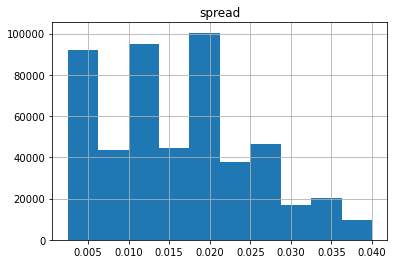

In [19]:
T_apr, ticksize = prep_data_sym(data, n_imb, dt, n_spread)
T_apr.hist('spread')

Таким образом, выделяются 16 спредов

In [20]:
T_apr, ticksize = prep_data_sym(data, n_imb, dt, n_spread)

[1.13661147e-03 5.47606781e-04 2.66890708e-04 1.29772876e-04
 6.30678141e-05 3.05767866e-05 1.48034529e-05 7.15898596e-06
 3.45967451e-06 1.67120215e-06 8.07027756e-07]


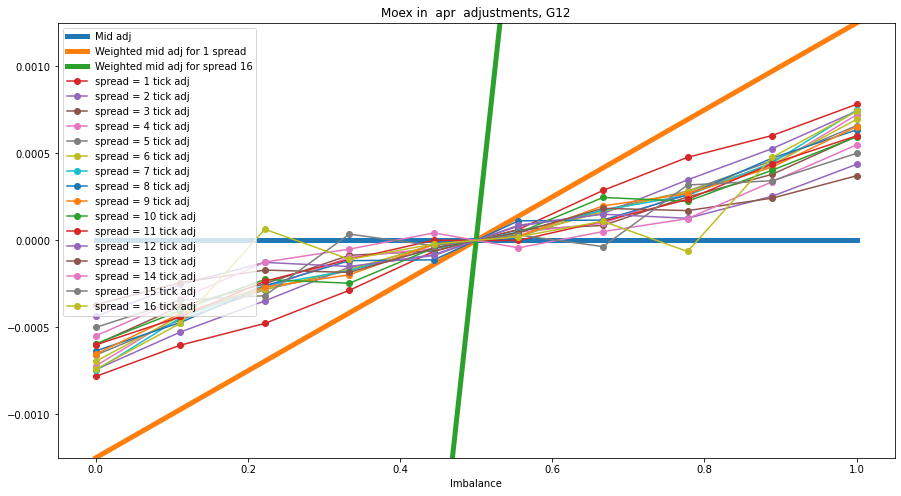

In [26]:
imb = np.linspace(0, 1, n_imb)
G1, B, Q, R1, R2, K = estimate(T_apr, n_spread, n_imb)

G = plot_Gstar(month, G1, B, T_apr, ticksize, n_spread, n_imb)
plt.show()

In [27]:
T_apr

,date,time,bid,bs,ask,as,mid,imb,wmid,spread,imb_bucket,next_mid,next_spread,next_time,next_imb_bucket,next_t1_mid,dM_t1_sec,next_t2_mid,dM_t2_sec,dM
0,19100.0,36033.0,80.2250,5000.0,80.2425,19000.0,80.23375,0.208333,80.228646,0.0175,3,80.23250,0.0200,36034.0,3.0,80.16750,-0.06625,80.26750,0.03375,-0.00125
1,19100.0,36066.0,80.1900,4000.0,80.2000,18000.0,80.19500,0.181818,80.191818,0.0100,3,80.19500,0.0100,36067.0,3.0,80.25625,0.06125,80.26750,0.07250,0.00000
2,19100.0,36067.0,80.1900,4000.0,80.2000,17000.0,80.19500,0.190476,80.191905,0.0100,3,80.19375,0.0075,36068.0,2.0,80.28500,0.09000,80.26750,0.07250,-0.00125
3,19100.0,36068.0,80.1900,4000.0,80.1975,50000.0,80.19375,0.074074,80.190556,0.0075,2,80.19500,0.0100,36069.0,1.0,80.28500,0.09125,80.25125,0.05750,0.00125
4,19100.0,36069.0,80.1900,4000.0,80.2000,62000.0,80.19500,0.060606,80.190606,0.0100,1,80.19500,0.0100,36072.0,8.0,80.30250,0.10750,80.25125,0.05625,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506785,19111.0,68377.0,71.2225,1000.0,71.2400,1000.0,-71.23125,0.500000,71.231250,0.0175,4,71.23000,0.0200,68378.0,1.0,NaN,NaN,NaN,NaN,0.00125
506786,19111.0,68378.0,71.2200,19000.0,71.2400,2000.0,-71.23000,0.904762,71.238095,0.0200,1,71.23000,0.0200,68379.0,1.0,NaN,NaN,NaN,NaN,-0.00000
506787,19111.0,68380.0,71.2200,14000.0,71.2275,70000.0,-71.22375,0.166667,71.221250,0.0075,7,71.22375,0.0075,68381.0,6.0,NaN,NaN,NaN,NaN,-0.00000
506788,19111.0,68381.0,71.2200,14000.0,71.2275,68000.0,-71.22375,0.170732,71.221280,0.0075,6,71.22375,0.0075,68383.0,7.0,NaN,NaN,NaN,NaN,-0.00000


## Прогнозы изменения средней цены

Теперь хотим понять, как хорошо micro-price предсказывает изменение средней цены ($M_t$) за временные промежутки t1 = 10 секунд, t2 = 30 секунд

In [28]:
def prep_data_sym_mod(T, n_imb, dt, t1, t2, n_spread):
    
    spread = T.ask - T.bid
    #ticksize = np.round(min(spread[spread > 0]) * 100)/100
    ticksize = np.round(min(spread[spread > 0]), decimals = 4)
    
    # adds the spread and mid prices
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize           # считаем спред как кол-во тиков * размер тика
    # T['mid'] = (T['bid'] + T['ask'])/2   mid уже есть в подающемся на вход T
    
    #filter out spreads >= n_spread                        # что такое n_spread?
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    #T['imb'] = T['bs'] / (T['bs'] + T['as'])   imb уже есть в подающемся на вход T
    
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)     # на n_imb - тили разбиваем имбаланс. дискретизируем как бы 
    T['next_mid'] = T['mid'].shift(-dt)                          # следующее значение (через время dt)
    
    #step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)  
    
    T['next_t1_mid'] = T['mid'].shift(-t1)
    T['dM_t1_sec'] = np.round((T['next_t1_mid'] - T['mid']) / ticksize*t1 )*ticksize/t1
    
    T['next_t2_mid'] = T['mid'].shift(-t2)
    T['dM_t2_sec'] = np.round((T['next_t2_mid'] - T['mid']) / ticksize*t2 )*ticksize/t2
    
    
    # step ahead change in price
    T['dM'] = np.round((T['next_mid'] - T['mid']) / ticksize*2 )*ticksize/2      # на пополам, потому что цена средняя, и когда бид или аск меняется на тик, среднее меняется на половину тика
    
    T = T[(T.dM <= ticksize*1.1) & (T.dM >= -ticksize*1.1)]           
    
    # symetrize data
    T2 = T.copy()                                                     # T2 - 'симметрично' T, то есть бид и аск меняем местами
    T2['imb_bucket'] = n_imb - 1 - T2['imb_bucket']
    T2['next_imb_bucket'] = n_imb - 1 - T2['next_imb_bucket']
    T2['dM'] = -T2['dM']
    T2['mid'] = -T2['mid']
    T2['dM_t1_sec'] = -T2['dM_t1_sec']
    T2['next_t1_mid'] = - T2['next_t1_mid']
    T2['dM_t2_sec'] = -T2['dM_t2_sec']
    T2['next_t2_mid'] = - T2['next_t2_mid']
    
    T3 = pd.concat([T,T2])                                                # склеиваем (подклеивам T2 снизу к Т)
    T3.index = pd.RangeIndex(len(T3.index))                               # сами устанавливаем индекс : 0, 1, 2, ...
    
    return T3, ticksize

In [33]:
t1 = 5
t2 = 10

T_apr, ticksize = prep_data_sym_mod(data, n_imb, dt, t1, t2, n_spread)

[1.13661147e-03 5.47606781e-04 2.66890708e-04 1.29772876e-04
 6.30678141e-05 3.05767866e-05 1.48034529e-05 7.15898596e-06
 3.45967451e-06 1.67120215e-06 8.07027756e-07]


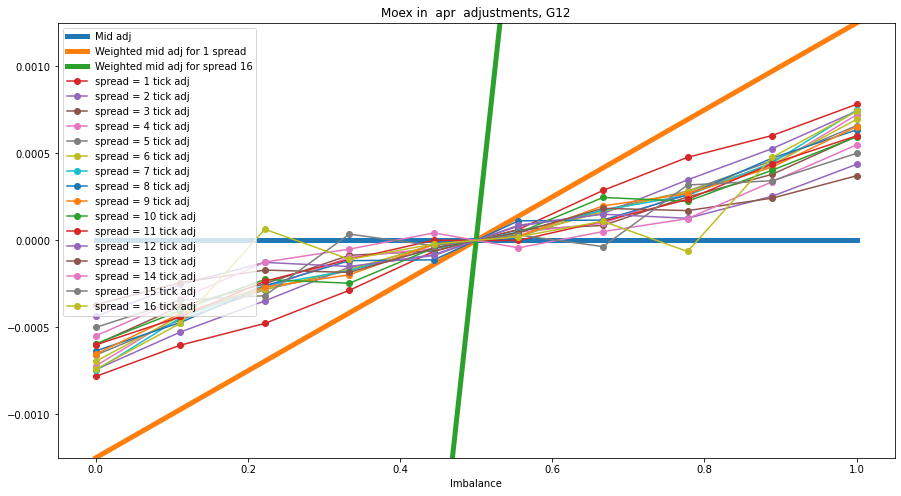

In [34]:
G = plot_Gstar(month, G1, B, T_apr, ticksize, n_spread, n_imb)

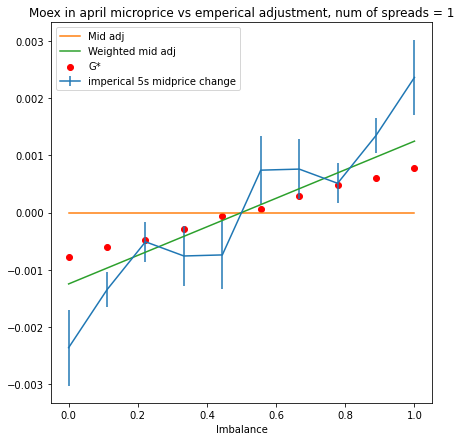

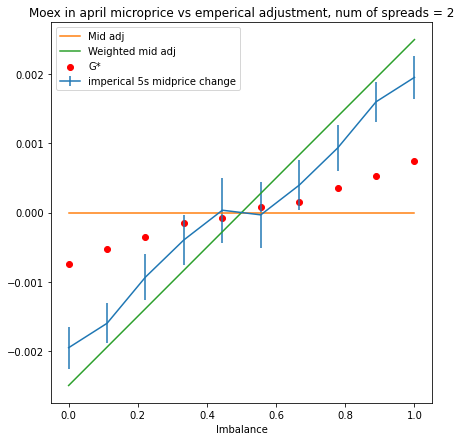

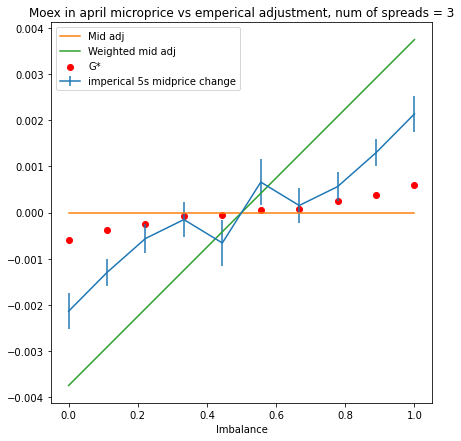

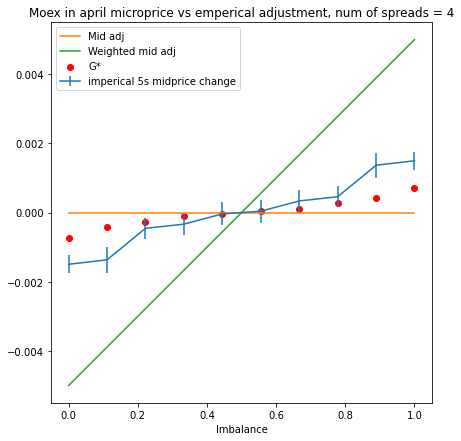

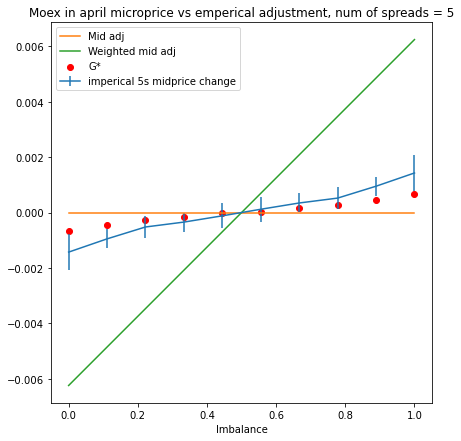

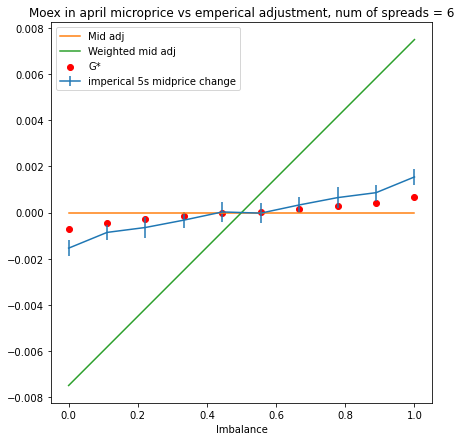

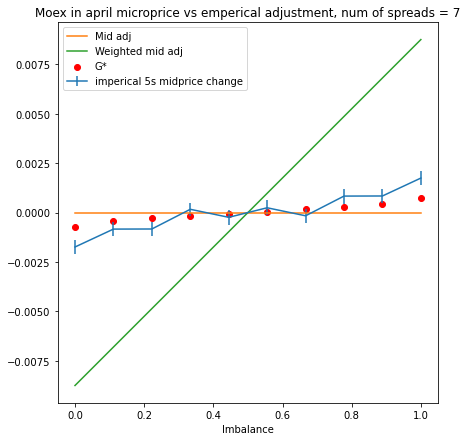

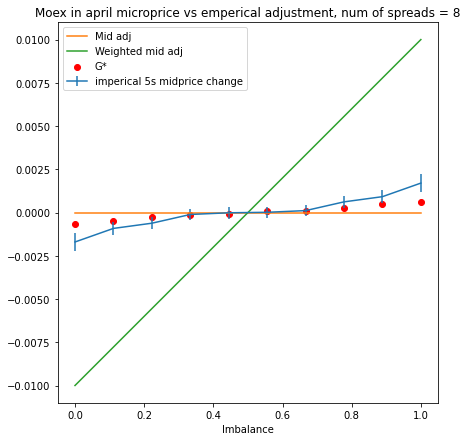

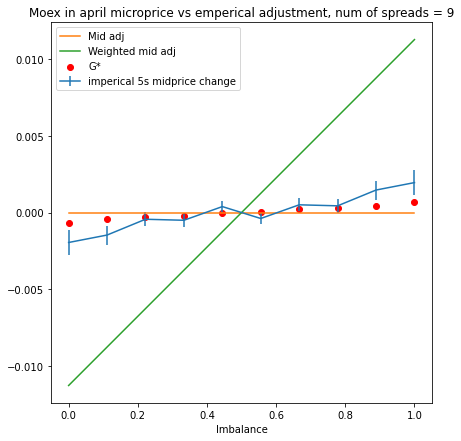

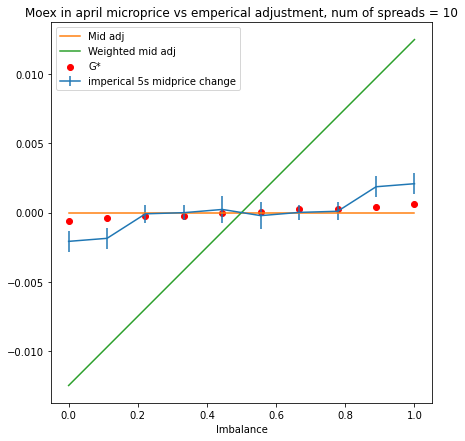

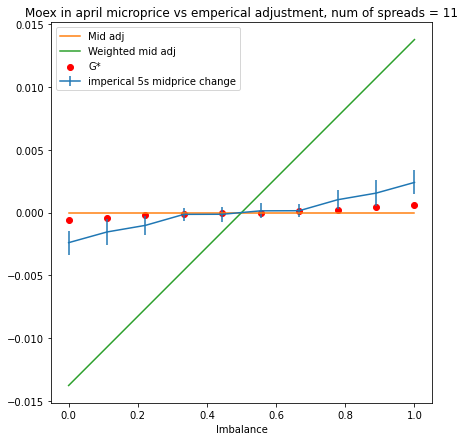

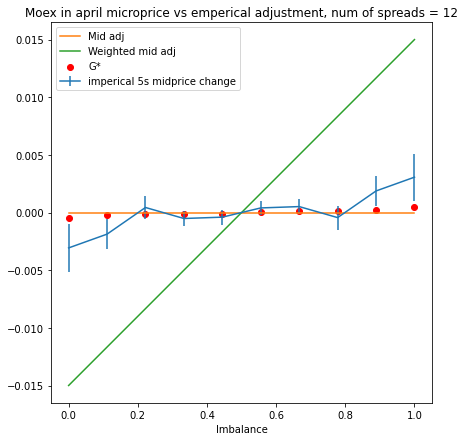

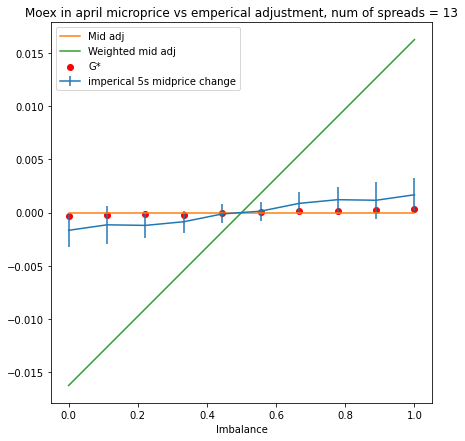

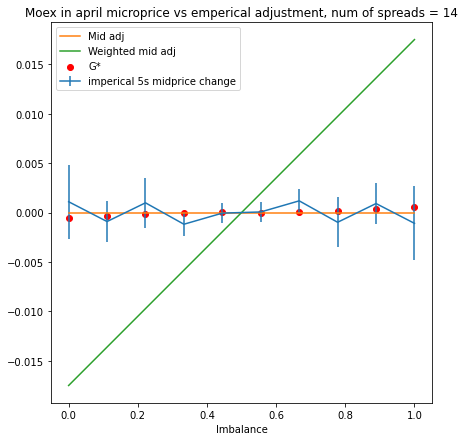

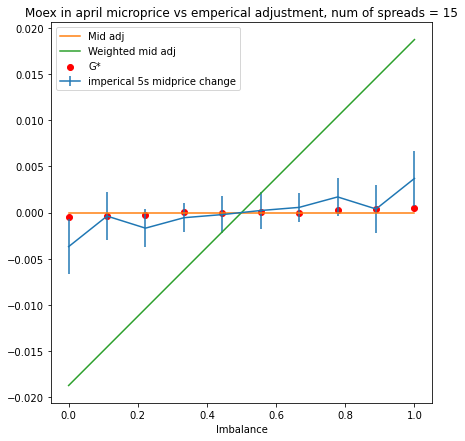

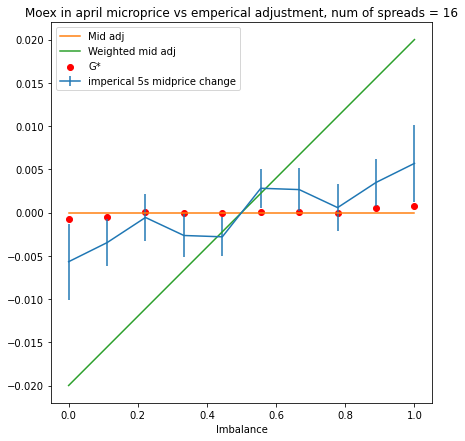

In [36]:
# уровень доверительного интервала
alpha = 0.99

tmp1 = np.zeros((n_spread, n_imb))
tmp2 = np.zeros((n_spread, n_imb))

tmp3 = np.zeros((n_spread, n_imb))
tmp4 = np.zeros((n_spread, n_imb))

for i in range(1, n_spread+1):
    for j in range(n_imb):
        df = T_apr[(T_apr['imb_bucket'] == j) & (T_apr['spread'] == i*ticksize)]
        tmp1[i-1][j] = df.dM_t1_sec.dropna().mean()
        std = df.dM_t1_sec.dropna().std()
        interval = stats.norm.interval(alpha=alpha, loc = tmp1[i-1][j], scale = std/np.sqrt(len(df)))
        tmp2[i-1][j] = 0.5*(interval[1] - interval[0])
        
        tmp3[i-1][j] = df.dM_t2_sec.dropna().mean()
        std = df.dM_t2_sec.dropna().std()
        interval = stats.norm.interval(alpha=alpha, loc = tmp1[i-1][j], scale = std/np.sqrt(len(df)))
        tmp4[i-1][j] = 0.5*(interval[1] - interval[0])
        
for i in range(1, n_spread+1):
    plt.figure(figsize = (15, 7))
    
    plt.subplot(1,2,1)
    
    plt.errorbar(imb, tmp1[i-1], yerr = tmp2[i-1], label = 'imperical {}s midprice change'.format(t1))
    plt.scatter(imb, G[((i-1)*n_imb):(i*n_imb)], color = 'red', label = 'G*')
    plt.plot(imb, np.linspace(-ticksize*0.5*i, 0.5*ticksize*i, n_imb) * 0, label = 'Mid adj')
    plt.plot(imb, np.linspace(-ticksize*0.5*i, 0.5*ticksize*i, n_imb), label = 'Weighted mid adj')
    plt.xlabel('Imbalance')
    plt.legend()
    plt.title('Moex in april microprice vs emperical adjustment, num of spreads = ' + str(i))
    '''
    plt.subplot(1,2,2)
    
    plt.errorbar(imb, tmp3[i-1], yerr = tmp4[i-1], label = 'imperical {}s midprice change'.format(t2))
    plt.scatter(imb, G[((i-1)*n_imb):(i*n_imb)], color = 'red', label = 'G*')
    plt.plot(imb, np.linspace(-ticksize*0.5*i, 0.5*ticksize*i, n_imb) * 0, label = 'Mid adj')
    plt.plot(imb, np.linspace(-ticksize*0.5*i, 0.5*ticksize*i, n_imb), label = 'Weighted mid adj')
    plt.xlabel('Imbalance')
    plt.legend()
    plt.title('Moex in april microprice vs emperical adjustment, spread = ' + str(i))
    ''' 
    plt.show()

## Автокорреляция

In [57]:
def autocorr(T, G, n_imb, n_spread, ticksize, dt):
    df = T.copy()
    
    arr = df['dMpr']
    print("Автокорреляция для micro-price = ", arr.autocorr(lag = 1))
    
    arr = df['dM']
    print("Автокорреляция для mid price = ", arr.autocorr(lag = 1))
    
    arr = df['dW']
    print("Автокорреляция для w mid price = ", arr.autocorr(lag = 1))
    

In [58]:
data = get_df(month)
new = prep_data_and_count_microprice(data, G, n_imb, dt, n_spread)
autocorr(new, G, n_imb, n_spread, ticksize, dt)

Автокорреляция для micro-price =  -0.0169074154453848
Автокорреляция для mid price =  -0.020133450833740893
Автокорреляция для w mid price =  -0.15011582598601128


In [41]:
data = get_df(month)
new = prep_data_and_count_microprice(data, G, n_imb, dt, n_spread)
autocorr(new, G, n_imb, n_spread, ticksize, dt)

Автокорреляция для micro-price =  0.9999968373864062
Автокорреляция для mid price =  0.9999965889782495
Автокорреляция для w mid price =  0.9999958257018854


In [37]:
new

,date,time,bid,bs,ask,as,mid,imb,wmid,spread,imb_bucket,mpr,next_mid,next_spread,next_time,next_imb_bucket,dM,dMpr,dW
32,19100.0,36033.0,80.2250,5000.0,80.2425,19000.0,80.23375,0.208333,80.228646,0.0175,3,80.233633,80.23250,0.0200,36034.0,3.0,-0.00125,-0.001331,-0.001979
65,19100.0,36066.0,80.1900,4000.0,80.2000,18000.0,80.19500,0.181818,80.191818,0.0100,3,80.194826,80.19500,0.0100,36067.0,3.0,0.00000,0.000000,0.000087
66,19100.0,36067.0,80.1900,4000.0,80.2000,17000.0,80.19500,0.190476,80.191905,0.0100,3,80.194826,80.19375,0.0075,36068.0,2.0,-0.00125,-0.001351,-0.001349
67,19100.0,36068.0,80.1900,4000.0,80.1975,50000.0,80.19375,0.074074,80.190556,0.0075,2,80.193475,80.19500,0.0100,36069.0,1.0,0.00125,0.001067,0.000051
68,19100.0,36069.0,80.1900,4000.0,80.2000,62000.0,80.19500,0.060606,80.190606,0.0100,1,80.194542,80.19500,0.0100,36072.0,8.0,0.00000,0.000915,0.007394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982776,19111.0,68377.0,71.2225,1000.0,71.2400,1000.0,71.23125,0.500000,71.231250,0.0175,5,71.231362,71.23000,0.0200,68378.0,8.0,-0.00125,-0.000941,0.006845
982777,19111.0,68378.0,71.2200,19000.0,71.2400,2000.0,71.23000,0.904762,71.238095,0.0200,8,71.230421,71.23000,0.0200,68379.0,8.0,0.00000,0.000000,-0.000201
982779,19111.0,68380.0,71.2200,14000.0,71.2275,70000.0,71.22375,0.166667,71.221250,0.0075,2,71.223475,71.22375,0.0075,68381.0,3.0,0.00000,0.000177,0.000030
982780,19111.0,68381.0,71.2200,14000.0,71.2275,68000.0,71.22375,0.170732,71.221280,0.0075,3,71.223652,71.22375,0.0075,68383.0,2.0,0.00000,-0.000177,-0.000491


## Приращения

In [28]:
data

,date,time,bid,bs,ask,as,mid,imb,wmid,spread
0,19100.0,36001.0,80.5225,32000.0,80.6375,50000.0,80.58000,0.390244,80.567378,0.1150
1,19100.0,36002.0,80.5200,9000.0,80.6375,50000.0,80.57875,0.152542,80.537924,0.1175
2,19100.0,36003.0,80.1475,100000.0,80.5125,6000.0,80.33000,0.943396,80.491840,0.3650
3,19100.0,36004.0,80.1900,35000.0,80.3025,38000.0,80.24625,0.479452,80.243938,0.1125
4,19100.0,36005.0,80.1325,67000.0,80.3025,9000.0,80.21750,0.881579,80.282368,0.1700
...,...,...,...,...,...,...,...,...,...,...
982794,19111.0,68395.0,71.1700,1000.0,71.2000,34000.0,71.18500,0.028571,71.170857,0.0300
982795,19111.0,68396.0,70.9600,16000.0,71.1975,52000.0,71.07875,0.235294,71.015882,0.2375
982796,19111.0,68397.0,70.9600,16000.0,71.1975,52000.0,71.07875,0.235294,71.015882,0.2375
982797,19111.0,68398.0,70.9600,16000.0,71.1600,4000.0,71.06000,0.800000,71.120000,0.2000


In [29]:
date = new['date'].unique()

In [30]:
date

array([19100., 19101., 19102., 19103., 19104., 19107., 19108., 19109.,
       19110., 19111.])

In [31]:
new

,date,time,bid,bs,ask,as,mid,imb,wmid,spread,imb_bucket,mpr,next_mid,next_spread,next_time,next_imb_bucket,dM,dMpr,dW
32,19100.0,36033.0,80.2250,5000.0,80.2425,19000.0,80.23375,0.208333,80.228646,0.0175,3,80.233633,80.23250,0.0200,36034.0,3.0,-0.00125,-0.001331,-0.001979
65,19100.0,36066.0,80.1900,4000.0,80.2000,18000.0,80.19500,0.181818,80.191818,0.0100,3,80.194826,80.19500,0.0100,36067.0,3.0,0.00000,0.000000,0.000087
66,19100.0,36067.0,80.1900,4000.0,80.2000,17000.0,80.19500,0.190476,80.191905,0.0100,3,80.194826,80.19375,0.0075,36068.0,2.0,-0.00125,-0.001351,-0.001349
67,19100.0,36068.0,80.1900,4000.0,80.1975,50000.0,80.19375,0.074074,80.190556,0.0075,2,80.193475,80.19500,0.0100,36069.0,1.0,0.00125,0.001067,0.000051
68,19100.0,36069.0,80.1900,4000.0,80.2000,62000.0,80.19500,0.060606,80.190606,0.0100,1,80.194542,80.19500,0.0100,36072.0,8.0,0.00000,0.000915,0.007394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982776,19111.0,68377.0,71.2225,1000.0,71.2400,1000.0,71.23125,0.500000,71.231250,0.0175,5,71.231362,71.23000,0.0200,68378.0,8.0,-0.00125,-0.000941,0.006845
982777,19111.0,68378.0,71.2200,19000.0,71.2400,2000.0,71.23000,0.904762,71.238095,0.0200,8,71.230421,71.23000,0.0200,68379.0,8.0,0.00000,0.000000,-0.000201
982779,19111.0,68380.0,71.2200,14000.0,71.2275,70000.0,71.22375,0.166667,71.221250,0.0075,2,71.223475,71.22375,0.0075,68381.0,3.0,0.00000,0.000177,0.000030
982780,19111.0,68381.0,71.2200,14000.0,71.2275,68000.0,71.22375,0.170732,71.221280,0.0075,3,71.223652,71.22375,0.0075,68383.0,2.0,0.00000,-0.000177,-0.000491


(Здесь такая странная нумерация точек, потому что мы часть данных выкидываем)

In [32]:
arr_dM = []
arr_dW = []
arr_dMpr = []


for d in date:
    arr_dM.append(new.loc[new['date'] == d].dM.mean())
    arr_dW.append(new.loc[new['date'] == d].dW.mean())
    arr_dMpr.append(new.loc[new['date'] == d].dMpr.mean())

In [33]:
arr_dM

[-1.882286269430051e-05,
 -5.735870173475102e-06,
 -2.6402961808261665e-05,
 -2.5541933191186914e-06,
 -1.6945773524720887e-05,
 -1.5116586674728802e-05,
 -1.486759425493708e-05,
 -1.5491472753505195e-05,
 2.907530981887511e-06,
 -6.581878569403382e-06]

In [34]:
arr_dW

[-5.047226502621602e-05,
 -1.382176967574262e-05,
 -5.54708120036918e-05,
 -1.3607510483646528e-05,
 -2.3461453490386625e-05,
 -2.9205540053967125e-05,
 -3.1309370754575134e-05,
 -3.2289821917664756e-05,
 -6.202394429802397e-07,
 -1.3778221109995115e-05]

In [35]:
arr_dMpr

[-2.0819655771675865e-05,
 -7.152599896445891e-06,
 -2.9187784902462578e-05,
 -4.57638511354324e-06,
 -1.667924956680542e-05,
 -1.4814420549247308e-05,
 -1.546129106976822e-05,
 -1.7588662444012312e-05,
 2.2282524429161385e-06,
 -5.081532768530348e-06]

Можно считать, что средние приращения 0